### Imports

In [7]:
import torch
import scico.numpy as snp
from scico import functional, linop, loss, metric, plot, random
from scico.examples import create_3d_foam_phantom, downsample_volume, tile_volume_slices
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

### Data Loading

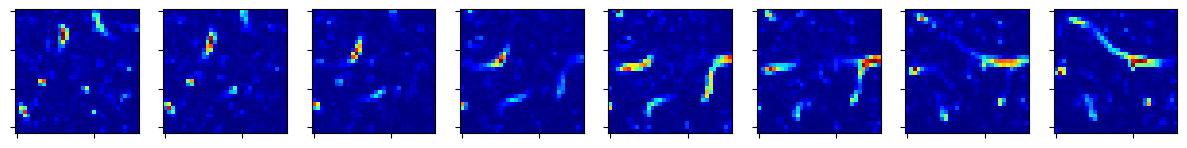

In [29]:
phi_comp=torch.load("./data/dataset/DMD/A.pt")['matrix']
phi_comp_u = torch.load("./data/dataset/DMD/Aa.pt")['matrix']*256
X = torch.load("./data/dataset/DMD/Xr_blood_cell.pt")
Y = torch.load("./data/dataset/DMD/Ym_blood_cell.pt")

b = 769
n_measure = 8196

x_gt = snp.array(X[b].view(8,32,32).cpu().numpy())
phi = snp.array(phi_comp[:n_measure,:].cpu().numpy())
phi_u = snp.array(phi_comp_u[:n_measure,:].cpu().numpy())
y = snp.array(Y[b][:n_measure].cpu().numpy())

σ = 10  # noise level
noise, key = random.randn(y.shape)
y_noisy = y + σ*noise



fig, ax = plot.subplots(nrows=1, ncols=8, figsize=(15, 4))
for i in range(8):
    plot.imview(x_gt[i], fig=fig, ax=ax[i],cmap = "jet")
    fig.show()

### Optimization Framework

Solving on CPU

Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  4.44e-01  2.107e+01  2.969e+02     20  2.402e-03
   1  8.84e-01  2.286e+01  4.756e+01     20  1.222e-03
   2  1.33e+00  2.394e+01  5.262e+01     20  1.059e-03
   3  1.76e+00  2.452e+01  5.545e+01     20  6.673e-04
   4  2.20e+00  2.504e+01  5.512e+01     20  7.280e-04
   5  2.63e+00  2.568e+01  5.612e+01     20  4.769e-04
   6  3.12e+00  2.630e+01  5.932e+01     20  5.671e-04
   7  3.56e+00  2.658e+01  5.922e+01     20  3.776e-04
   8  4.00e+00  2.681e+01  5.649e+01     20  4.694e-04
   9  4.49e+00  2.740e+01  5.648e+01     20  3.166e-04
  10  4.93e+00  2.806e+01  6.106e+01     20  4.181e-04
  11  5.37e+00  2.818e+01  6.123e+01     20  2.724e-04
  12  5.80e+00  2.835e+01  5.702e+01     20  4.226e-04
  13  6.25e+00  2.888e+01  5.655e+01     20  2.404e-04
  14  6.68e+00  2.953e+01  6.153e+01     20  3.639e-04
  15  7.13e+00  2.965e+01  6.218e+01     20  2.19

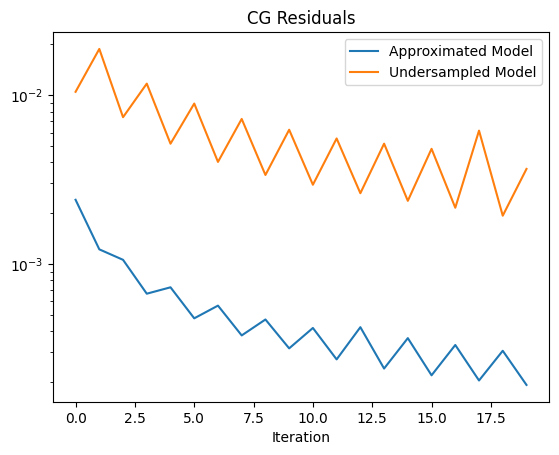

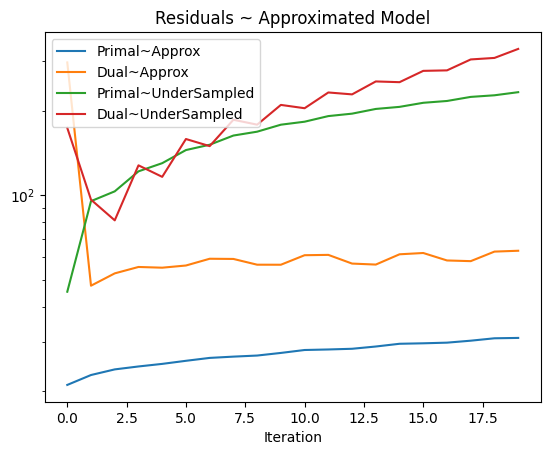

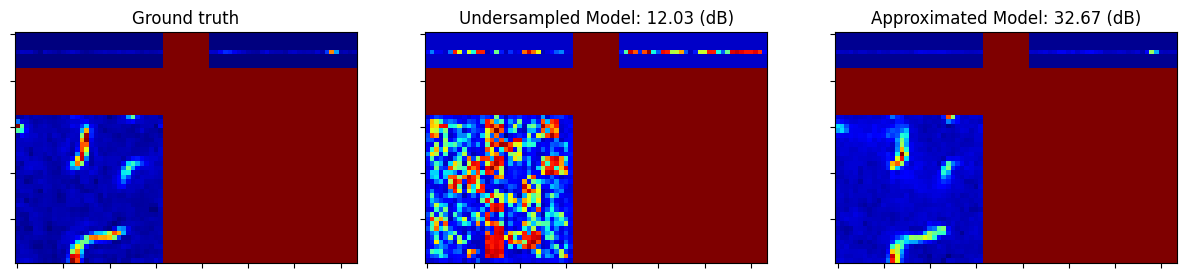

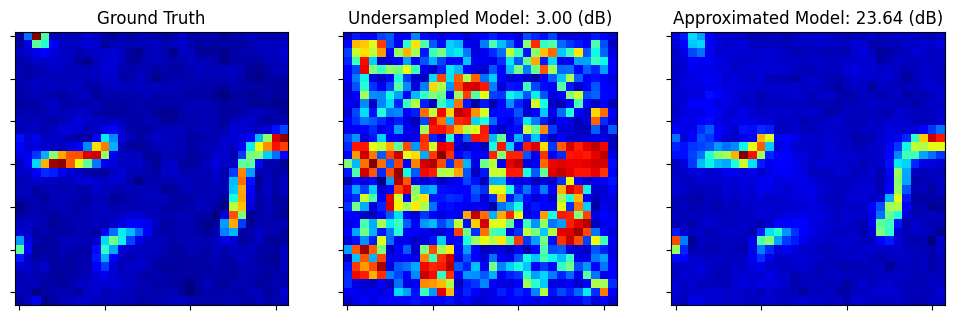

In [30]:
g_sub = functional.DnCNN("6L")
class MyFunctional(functional.Functional):
     has_eval = False
     has_prox = True
     
     def __init__(self):
          pass
     def prox(self, x, lam = .01,**kwargs) :
          x = x.at[:4,:, :].set(0)
          x = x.at[5:,:, :].set(0)
          x = x.at[4,:, :].set(2* g_sub.prox(x[4,:,:], lam=lam))
          return x
     
g = MyFunctional()
C = linop.Identity(x_gt.shape)
ρ = 1e1
maxiter = 20


# Approximated Model
Afn = lambda x: phi@x.flatten()
A = linop.LinearOperator(input_shape = x_gt.shape, output_shape = y.shape, eval_fn=Afn)

f = loss.SquaredL2Loss(y=y_noisy, A=A)

x_init = (A.T @ y_noisy)
x_init = (x_init-x_init.min())/(x_init.max()-x_init.min())

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=x_init,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-5, "maxiter": 20}),
    itstat_options={"display": True},
)


print(f"Solving on {device_info()}\n")
x = solver.solve()
x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)


# Undersampled Model
Afn_u = lambda x: phi_u@x.flatten()
Au = linop.LinearOperator(input_shape = x_gt.shape, output_shape = y.shape, eval_fn=Afn_u)


fu = loss.SquaredL2Loss(y=y_noisy, A=Au)

x_init = (Au.T @ y_noisy)
x_init = (x_init-x_init.min())/(x_init.max()-x_init.min())

solver_u = ADMM(
    f=fu,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=x_init,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-5, "maxiter": 20}),
    itstat_options={"display": True},
)


print(f"Solving on {device_info()}\n")
x_u = solver_u.solve()
x_u = snp.clip(x_u, 0, 1)
hist_u = solver_u.itstat_object.history(transpose=True)


plot.plot(
    snp.vstack((hist.CG_Res, hist_u.CG_Res)).T,
    ptyp="semilogy",
    title="CG Residuals",
    xlbl="Iteration",
    lgnd=("Approximated Model", "Undersampled Model"),
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl, hist_u.Prml_Rsdl, hist_u.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals ~ Approximated Model",
    xlbl="Iteration",
    lgnd=("Primal~Approx", "Dual~Approx", "Primal~UnderSampled", "Dual~UnderSampled"),
)


x_gt,x, x_u = g.prox(x_gt, lam = 1e-4), g.prox(x, lam = 1e-6), g.prox(x_u, lam = 1e-6)

# Qualitative and Quatitative Verification

fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(tile_volume_slices(x_gt), title="Ground truth", fig=fig, ax=ax[0],cmap = 'jet')
plot.imview(tile_volume_slices(x_u,sep_width=10), title="Undersampled Model: %.2f (dB)" % metric.psnr(x_gt, x_u), fig=fig, ax=ax[1],cmap = 'jet' )
plot.imview(tile_volume_slices(x,sep_width=10), title="Approximated Model: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[2],cmap = 'jet' )
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(12, 4))
plot.imview(x_gt[4],fig=fig, ax=ax[0], cmap= 'jet', title="Ground Truth")
plot.imview(x_u[4],fig=fig, ax=ax[1], cmap= 'jet', title="Undersampled Model: %.2f (dB)" % metric.psnr(x_gt[4], x_u[4]))
plot.imview(x[4],fig=fig, ax=ax[2], cmap= 'jet',  title="Approximated Model: %.2f (dB)" % metric.psnr(x_gt[4], x[4]))
fig.show()

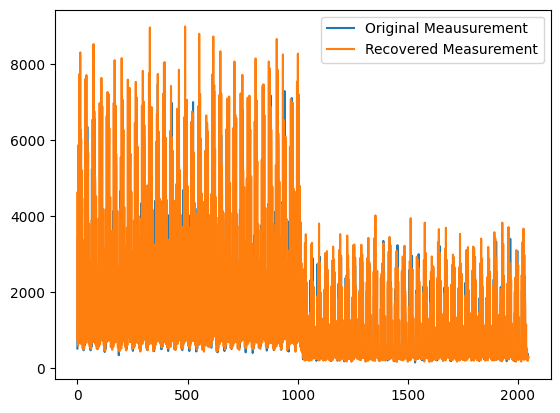

In [10]:
p = snp.vstack((snp.array(y_noisy), snp.array(Afn(x))))
plot.plot(p.reshape(-1,2), lgnd=["Original Meausurement", "Recovered Measurement"])

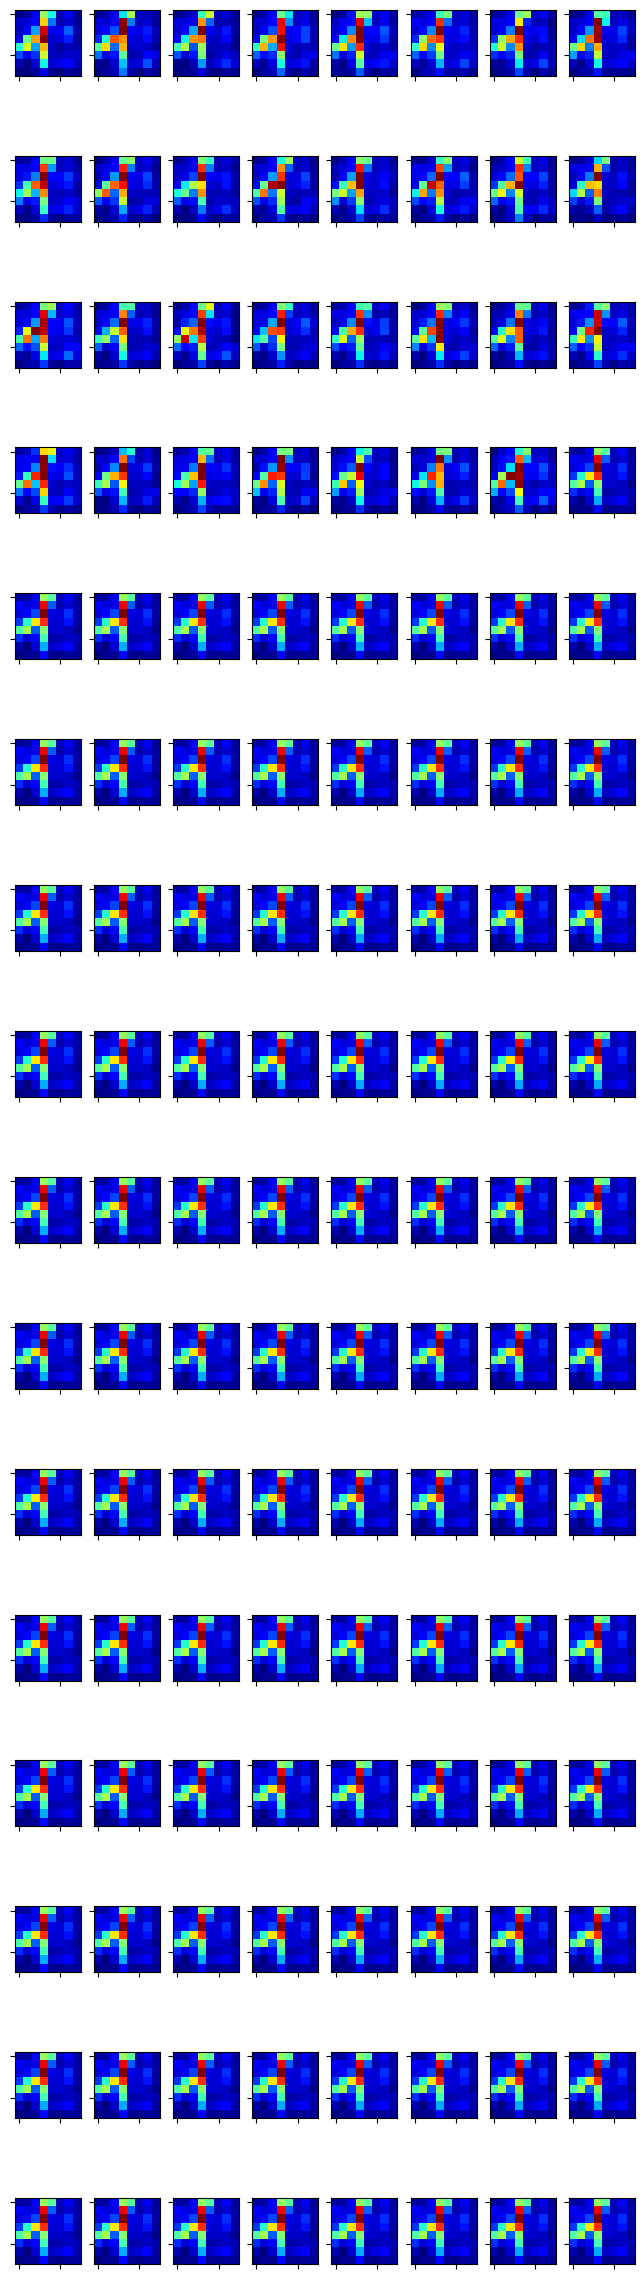

In [11]:
measure = y.reshape(-1,8, 8)
fig, ax = plot.subplots(nrows=16, ncols=8, figsize=(8, 30))
for i in range(128):
    row, col= i//8, i%8
    plot.imview(measure[i], fig=fig, ax=ax[row][col],cmap = "jet")
    fig.show()